In [11]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.colors import LinearSegmentedColormap
import os
import torch
import torch.nn as nn
from torch.optim.lr_scheduler import ReduceLROnPlateau
from astropy.io import fits
from astropy.table import Table, Column
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
import pickle
from astropy.coordinates import SkyCoord
import astropy.units as u
import pandas as pd

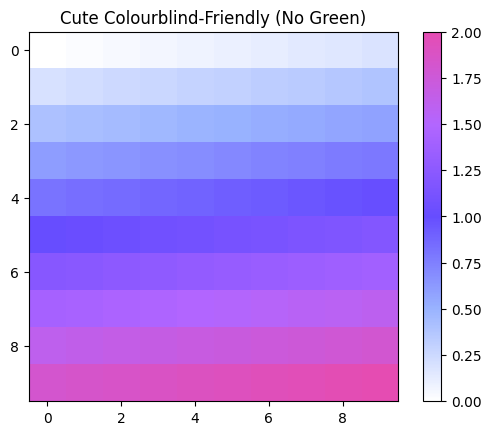

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

# No green! Still white at 0 density, and colourblind-friendly.
colours = [
    (1.0, 1.0, 1.0),  # white
    (0.6, 0.7, 1.0),  # soft blue
    (0.4, 0.3, 1.0),  # periwinkle
    (0.7, 0.4, 1.0),  # lavender
    (0.9, 0.3, 0.7)   # soft pink-magenta
]

# Create the colormap
cmap = LinearSegmentedColormap.from_list("cute_cb_nogreen", colours, N=256)

# Example data
data = np.linspace(0, 2, 100).reshape(10, 10)

# Plot
plt.imshow(data, cmap=cmap, vmin=0, vmax=2)
plt.colorbar()
plt.title('Cute Colourblind-Friendly (No Green)')
plt.show()



In [12]:
file = "/raid/DESI/spectra/loa_trainingset.fits"

In [13]:
#get the apogee data
with fits.open(file) as hdul:
    apogee_data = Table(hdul['APOGEE'].data)

columns_to_keep = ['APOGEE_ID', 'RA', 'DEC', 'SNR', 'FE_H', 
                   'FE_H_ERR', 'LOGG', 'TEFF', 'LOGG_ERR', 
                   'TEFF_ERR', 'PARAMFLAG', 'ASPCAPFLAG', 
                   'MG_FE', 'MG_FE_ERR', 'C_FE', 'C_FE_ERR', 
                   'SI_FE', 'SI_FE_ERR', 'NI_FE', 'NI_FE_ERR', 
                   'AL_FE', 'AL_FE_ERR', 'CA_FE', 'CA_FE_ERR', 
                   'N_FE', 'N_FE_ERR']

apogee_selected = apogee_data[columns_to_keep] 

In [14]:
# get the spectra
with fits.open(file) as hdul:
    spectra_data = Table(hdul['SPECTRA'].data)  # 38836 rows, each 7650 flux values
    wavelength_data = Table(hdul['WAVELENGTH'].data)  # 7650 rows, 1 column

In [15]:
gb_combined_spectra = Table(names=['combined_flux', 'combined_wavelength'], dtype=['object', 'object'])

wavelength = wavelength_data['WAVELENGTH']  #same for all stars

for row in spectra_data:
    flux = row['FLUX']

    global_median = np.median(flux)
    IQR = np.percentile(flux, 75) - np.percentile(flux, 25)
   
    normalized_flux = (flux - global_median) / IQR

    gb_combined_spectra.add_row([normalized_flux, wavelength])

flux_array = np.array(gb_combined_spectra['combined_flux'])

In [16]:
X = np.array([np.array(flux_val, dtype=float) for flux_val in flux_array])

If you have already downloaded the y input file and the params file, you can skip right past all of this. This is just how I saved all the labels and the data cleaning process.

In [53]:
abnormal_rows = (
    # feh conditions
    np.isnan(apogee_selected['FE_H']) | 
    (apogee_selected['FE_H'] > 10) | 
    (apogee_selected['FE_H'] == 0) |
    (apogee_selected['FE_H_ERR'] == 0) | 
    np.isnan(apogee_selected['FE_H_ERR']) |      

    # logg conditions
    np.isnan(apogee_selected['LOGG']) | 
    (apogee_selected['LOGG'] >= 6) | 
    (apogee_selected['LOGG'] == 0) |
    (apogee_selected['LOGG_ERR'] == 0) |
    np.isnan(apogee_selected['LOGG_ERR']) |

    # teff conditions
    np.isnan(apogee_selected['TEFF']) | 
    (apogee_selected['TEFF'] > 10000) | 
    (apogee_selected['TEFF'] == 0) |
    (apogee_selected['TEFF_ERR'] == 0) |
    np.isnan(apogee_selected['TEFF_ERR']) |

    # mgfe conditions
    np.isnan(apogee_selected['MG_FE']) | 
    (apogee_selected['MG_FE'] > 10) | 
    (apogee_selected['MG_FE'] == 0) |
    (apogee_selected['MG_FE_ERR'] == 0) |
    np.isnan(apogee_selected['MG_FE_ERR']) |

    # cfe conditions
    np.isnan(apogee_selected['C_FE']) | 
    (apogee_selected['C_FE'] > 10) | 
    (apogee_selected['C_FE'] == 0) |
    (apogee_selected['C_FE_ERR'] == 0) |
    np.isnan(apogee_selected['C_FE_ERR']) |
    
     # sife conditions
    np.isnan(apogee_selected['SI_FE']) | 
    (apogee_selected['SI_FE'] > 10) | 
    (apogee_selected['SI_FE'] == 0) |
    (apogee_selected['SI_FE_ERR'] == 0) |
    np.isnan(apogee_selected['SI_FE_ERR']) |
    
     # nife conditions
    np.isnan(apogee_selected['NI_FE']) | 
    (apogee_selected['NI_FE'] > 10) | 
    (apogee_selected['NI_FE'] == 0) |
    (apogee_selected['NI_FE_ERR'] == 0) |
    np.isnan(apogee_selected['NI_FE_ERR']) |
    
    #alfe conditions
    np.isnan(apogee_selected['AL_FE']) | 
    (apogee_selected['AL_FE'] > 10) | 
    (apogee_selected['AL_FE'] == 0) |
    (apogee_selected['AL_FE_ERR'] == 0) |
    np.isnan(apogee_selected['AL_FE_ERR']) |
    
    #cafe conditions
    np.isnan(apogee_selected['CA_FE']) | 
    (apogee_selected['CA_FE'] > 10) | 
    (apogee_selected['CA_FE'] == 0) |
    (apogee_selected['CA_FE_ERR'] == 0) |
    np.isnan(apogee_selected['CA_FE_ERR']) |
    
    #nfe conditions
    np.isnan(apogee_selected['N_FE']) | 
    (apogee_selected['N_FE'] > 10) | 
    (apogee_selected['N_FE'] == 0) |
    (apogee_selected['N_FE_ERR'] == 0) |
    np.isnan(apogee_selected['N_FE_ERR'])
)

mask = ~abnormal_rows

# apply mask
apogee_masked = apogee_selected[mask]

mean_feh = np.mean(apogee_masked['FE_H'])
mean_logg = np.mean(apogee_masked['LOGG'])
mean_teff = np.mean(apogee_masked['TEFF'])
mean_mgfe = np.mean(apogee_masked['MG_FE'])
mean_cfe = np.mean(apogee_masked['C_FE'])
mean_sife = np.mean(apogee_masked['SI_FE'])
mean_nife = np.mean(apogee_masked['NI_FE'])
mean_alfe = np.mean(apogee_masked['AL_FE'])
mean_cafe = np.mean(apogee_masked['CA_FE'])
mean_nfe = np.mean(apogee_masked['N_FE'])

In [56]:
#Here we create seperate masks to apply to metals, teff, logg, c
param_flags = apogee_selected['PARAMFLAG'] #each row is an array len = 9
aspcap_flags = apogee_selected['ASPCAPFLAG'] #each row is a single value

# Define bitmasks for ASPCAPFLAG
teff_bad_mask = (1 << 16) # TEFF_BAD
colorte_bad_mask = (1 << 25) # COLORTE_BAD
logg_bad_mask = (1 << 17) # LOGG_BAD
star_bad_mask = (1 << 23) # STAR_BAD
m_h_bad_mask = (1 << 19) # M_H_BAD
c_m_bad_mask = (1 << 21) # C_M_BAD
n_m_bad_mask = (1 << 22) # N_M_BAD

# Define bitmasks for PARAMFLAG
gridedge_bad_mask = (1 << 0) # GRIDEDGE_BAD
calrange_bad_mask = (1 << 1) # CALRANGE_BAD
other_bad_mask = (1 << 2) # OTHER_BAD
teff_cut_mask = (1 << 6) # TEFF_CUT

# Define index positions in PARAMFLAG array
logg_index = 1
teff_index = 0
metal_index = 3
carbon_index = 5
nitrogen_index = 6

# Separate masks for each parameter:
# TEFF specific issues
teff_param_issues = (param_flags[:, teff_index] & (gridedge_bad_mask | calrange_bad_mask | other_bad_mask | teff_cut_mask)) != 0
teff_aspcap_issues = (aspcap_flags & (teff_bad_mask | colorte_bad_mask | star_bad_mask)) != 0
teff_issues = teff_param_issues | teff_aspcap_issues

# LOGG specific issues
logg_param_issues = (param_flags[:, logg_index] & (gridedge_bad_mask | calrange_bad_mask | other_bad_mask)) != 0
logg_aspcap_issues = (aspcap_flags & (logg_bad_mask | star_bad_mask)) != 0
logg_issues = logg_param_issues | logg_aspcap_issues

# Metal specific issues 
metal_param_issues = (param_flags[:, metal_index] & (gridedge_bad_mask | calrange_bad_mask | other_bad_mask)) != 0
metal_aspcap_issues = (aspcap_flags & m_h_bad_mask) != 0
metal_issues = metal_param_issues | metal_aspcap_issues

# Carbon specific issues
carbon_param_issues = (param_flags[:, carbon_index] & (gridedge_bad_mask | calrange_bad_mask | other_bad_mask)) != 0
carbon_aspcap_issues = (aspcap_flags & c_m_bad_mask) != 0
carbon_issues = carbon_param_issues | carbon_aspcap_issues

# Nitrogen specific issues 
nitrogen_param_issues = (param_flags[:, nitrogen_index] & (gridedge_bad_mask | calrange_bad_mask | other_bad_mask)) != 0
nitrogen_aspcap_issues = (aspcap_flags & n_m_bad_mask) != 0
nitrogen_issues = nitrogen_param_issues | nitrogen_aspcap_issues

# replaces bad values from specific masks
apogee_selected['TEFF'][teff_issues] = mean_teff
apogee_selected['TEFF_ERR'][teff_issues] = 10000

apogee_selected['LOGG'][logg_issues] = mean_logg
apogee_selected['LOGG_ERR'][logg_issues] = 200

apogee_selected['FE_H'][metal_issues] = mean_feh
apogee_selected['FE_H_ERR'][metal_issues] = 100

apogee_selected['MG_FE'][metal_issues] = mean_mgfe
apogee_selected['MG_FE_ERR'][metal_issues] = 100

apogee_selected['SI_FE'][metal_issues] = mean_sife
apogee_selected['SI_FE_ERR'][metal_issues] = 100

apogee_selected['NI_FE'][metal_issues] = mean_nife
apogee_selected['NI_FE_ERR'][metal_issues] = 100

apogee_selected['AL_FE'][metal_issues] = mean_alfe
apogee_selected['AL_FE_ERR'][metal_issues] = 100

apogee_selected['CA_FE'][metal_issues] = mean_cafe
apogee_selected['CA_FE_ERR'][metal_issues] = 100

apogee_selected['C_FE'][carbon_issues] = mean_cfe
apogee_selected['C_FE_ERR'][carbon_issues] = 100

apogee_selected['N_FE'][nitrogen_issues] = mean_nfe
apogee_selected['N_FE_ERR'][nitrogen_issues] = 100

In [57]:
#as a series of specific masks
# FE_H mask
feh_abnormal = (
    np.isnan(apogee_selected['FE_H']) | 
    (apogee_selected['FE_H'] > 10) | 
    (apogee_selected['FE_H'] == 0) |
    (apogee_selected['FE_H_ERR'] == 0) | 
    np.isnan(apogee_selected['FE_H_ERR'])
)

# LOGG 
logg_abnormal = (
    np.isnan(apogee_selected['LOGG']) | 
    (apogee_selected['LOGG'] >= 6) | 
    (apogee_selected['LOGG'] == 0) |
    (apogee_selected['LOGG_ERR'] == 0) |
    np.isnan(apogee_selected['LOGG_ERR'])
)

# TEFF 
teff_abnormal = (
    np.isnan(apogee_selected['TEFF']) | 
    (apogee_selected['TEFF'] > 10000) | 
    (apogee_selected['TEFF'] == 0) |
    (apogee_selected['TEFF_ERR'] == 0) |
    np.isnan(apogee_selected['TEFF_ERR'])
)

# MG_FE 
mgfe_abnormal = (
    np.isnan(apogee_selected['MG_FE']) | 
    (apogee_selected['MG_FE'] > 10) | 
    (apogee_selected['MG_FE'] == 0) |
    (apogee_selected['MG_FE_ERR'] == 0) |
    np.isnan(apogee_selected['MG_FE_ERR'])
)

# C_FE 
cfe_abnormal = (
    np.isnan(apogee_selected['C_FE']) | 
    (apogee_selected['C_FE'] > 10) | 
    (apogee_selected['C_FE'] == 0) |
    (apogee_selected['C_FE_ERR'] == 0) |
    np.isnan(apogee_selected['C_FE_ERR'])
)

# SI_FE
sife_abnormal = (
    np.isnan(apogee_selected['SI_FE']) | 
    (apogee_selected['SI_FE'] > 10) | 
    (apogee_selected['SI_FE'] == 0) |
    (apogee_selected['SI_FE_ERR'] == 0) |
    np.isnan(apogee_selected['SI_FE_ERR'])
)

# NI_FE 
nife_abnormal = (
    np.isnan(apogee_selected['NI_FE']) | 
    (apogee_selected['NI_FE'] > 10) | 
    (apogee_selected['NI_FE'] == 0) |
    (apogee_selected['NI_FE_ERR'] == 0) |
    np.isnan(apogee_selected['NI_FE_ERR'])
)

# AL_FE 
alfe_abnormal = (
    np.isnan(apogee_selected['AL_FE']) | 
    (apogee_selected['AL_FE'] > 10) | 
    (apogee_selected['AL_FE'] == 0) |
    (apogee_selected['AL_FE_ERR'] == 0) |
    np.isnan(apogee_selected['AL_FE_ERR'])
)


# CA_FE 
cafe_abnormal = (
    np.isnan(apogee_selected['CA_FE']) | 
    (apogee_selected['CA_FE'] > 10) | 
    (apogee_selected['CA_FE'] == 0) |
    (apogee_selected['CA_FE_ERR'] == 0) |
    np.isnan(apogee_selected['CA_FE_ERR'])
)


# N_FE 
nfe_abnormal = (
    np.isnan(apogee_selected['N_FE']) | 
    (apogee_selected['N_FE'] > 10) | 
    (apogee_selected['N_FE'] == 0) |
    (apogee_selected['N_FE_ERR'] == 0) |
    np.isnan(apogee_selected['N_FE_ERR'])
)


# Replace bad values using separate masks for each parameter
apogee_selected['FE_H'][feh_abnormal] = mean_feh
apogee_selected['FE_H_ERR'][feh_abnormal] = 100

apogee_selected['TEFF'][teff_abnormal] = mean_teff
apogee_selected['TEFF_ERR'][teff_abnormal] = 10000

apogee_selected['LOGG'][logg_abnormal] = mean_logg
apogee_selected['LOGG_ERR'][logg_abnormal] = 200

apogee_selected['MG_FE'][mgfe_abnormal] = mean_mgfe
apogee_selected['MG_FE_ERR'][mgfe_abnormal] = 100

apogee_selected['C_FE'][cfe_abnormal] = mean_cfe
apogee_selected['C_FE_ERR'][cfe_abnormal] = 100

apogee_selected['SI_FE'][sife_abnormal] = mean_sife
apogee_selected['SI_FE_ERR'][sife_abnormal] = 100

apogee_selected['NI_FE'][nife_abnormal] = mean_nife
apogee_selected['NI_FE_ERR'][nife_abnormal] = 100

apogee_selected['AL_FE'][alfe_abnormal] = mean_alfe
apogee_selected['AL_FE_ERR'][alfe_abnormal] = 100

apogee_selected['CA_FE'][cafe_abnormal] = mean_cafe
apogee_selected['CA_FE_ERR'][cafe_abnormal] = 100

apogee_selected['N_FE'][nfe_abnormal] = mean_nfe
apogee_selected['N_FE_ERR'][nfe_abnormal] = 100

In [59]:
#normalize the data
feh = np.array(apogee_selected['FE_H'])
logg = np.array(apogee_selected['LOGG'])
teff = np.array(apogee_selected['TEFF'])
mgfe = np.array(apogee_selected['MG_FE'])
cfe = np.array(apogee_selected['C_FE'])
sife = np.array(apogee_selected['SI_FE'])
nife = np.array(apogee_selected['NI_FE'])
alfe = np.array(apogee_selected['AL_FE'])
cafe = np.array(apogee_selected['CA_FE'])
nfe = np.array(apogee_selected['N_FE'])


# get 25th and 75th percentiles
feh_IQR = np.percentile(feh, 75) - np.percentile(feh, 25)
logg_IQR = np.percentile(logg, 75) - np.percentile(logg, 25)
teff_IQR = np.percentile(teff, 75) - np.percentile(teff, 25)
mgfe_IQR = np.percentile(mgfe, 75) - np.percentile(mgfe, 25)
cfe_IQR = np.percentile(cfe, 75) - np.percentile(cfe, 25)
sife_IQR = np.percentile(sife, 75) - np.percentile(sife, 25)
nife_IQR = np.percentile(nife, 75) - np.percentile(nife, 25)
alfe_IQR = np.percentile(alfe, 75) - np.percentile(alfe, 25)
cafe_IQR = np.percentile(cafe, 75) - np.percentile(cafe, 25)
nfe_IQR = np.percentile(nfe, 75) - np.percentile(nfe, 25)

#medians
feh_median = np.median(feh)
logg_median = np.median(logg)
teff_median = np.median(teff)
mgfe_median = np.median(mgfe)
cfe_median = np.median(cfe)
sife_median = np.median(sife)
nife_median = np.median(nife)
alfe_median = np.median(alfe)
cafe_median = np.median(cafe)
nfe_median = np.median(nfe)

log_teff = np.log10(teff)
log_teff_median = np.median(log_teff)
log_teff_IQR = np.percentile(log_teff, 75) - np.percentile(log_teff, 25)

This saves all of the params that normalized the labels so that we can "unnormalize" the predictions, once saved you don't need to do this.

In [61]:
params = {
    'feh': {'median': feh_median, 'IQR': feh_IQR},
    'logg': {'median': logg_median, 'IQR': logg_IQR},
    'teff': {'median': teff_median, 'IQR': teff_IQR, 'log_median': log_teff_median, 'log_IQR': log_teff_IQR},
    'mgfe': {'median': mgfe_median, 'IQR': mgfe_IQR},
    'cfe': {'median': cfe_median, 'IQR': cfe_IQR},
    'sife': {'median': sife_median, 'IQR': sife_IQR},
    'nife': {'median': nife_median, 'IQR': nife_IQR},
    'alfe': {'median': alfe_median, 'IQR': alfe_IQR},
    'cafe': {'median': cafe_median, 'IQR': cafe_IQR},
    'nfe': {'median': nfe_median, 'IQR': nfe_IQR}
}
    
with open('params_loa.pkl', 'wb') as f:
    pickle.dump(params, f)

In [62]:
# feh_target
feh_target = (feh - feh_median) / feh_IQR
feh_err = apogee_selected['FE_H_ERR'] / feh_IQR 
feh_error = np.full_like(feh_target, feh_err)

# logg_target
logg_median = np.median(logg)
logg_IQR = np.percentile(logg, 75) - np.percentile(logg, 25)
logg_target = (logg - logg_median) / logg_IQR
logg_err = apogee_selected['LOGG_ERR'] / logg_IQR
logg_error = np.full_like(logg_target, logg_err)

# teff_target
log_teff = np.log10(teff)
log_teff_median = np.median(log_teff)
log_teff_IQR = np.percentile(log_teff, 75) - np.percentile(log_teff, 25)
teff_target = (log_teff - log_teff_median) / log_teff_IQR
teff_err = apogee_selected['TEFF_ERR'] / (teff * np.log(10)) 
teff_error = teff_err / log_teff_IQR  

# mgfe_target
mgfe_target = (mgfe - mgfe_median) / mgfe_IQR
mgfe_err = apogee_selected['MG_FE_ERR'] / mgfe_IQR
mgfe_error = np.full_like(mgfe_target, mgfe_err)

#cfe_target
cfe_target = (cfe - cfe_median) / cfe_IQR
cfe_err = apogee_selected['C_FE_ERR'] / cfe_IQR
cfe_error = np.full_like(cfe_target, cfe_err)

#sife_target
sife_target = (sife - sife_median) / sife_IQR
sife_err = apogee_selected['SI_FE_ERR'] / sife_IQR
sife_error = np.full_like(sife_target, sife_err)

#nife_target
nife_target = (nife - nife_median) / nife_IQR
nife_err = apogee_selected['NI_FE_ERR'] / nife_IQR
nife_error = np.full_like(nife_target, nife_err)

#alfe_target
alfe_target = (alfe - alfe_median) / alfe_IQR
alfe_err = apogee_selected['AL_FE_ERR'] / alfe_IQR
alfe_error = np.full_like(alfe_target, alfe_err)

#cafe_target
cafe_target = (cafe - cafe_median) / cafe_IQR
cafe_err = apogee_selected['CA_FE_ERR'] / cafe_IQR
cafe_error = np.full_like(cafe_target, cafe_err)

#nfe_target
nfe_target = (nfe - nfe_median) / nfe_IQR
nfe_err = apogee_selected['N_FE_ERR'] / nfe_IQR
nfe_error = np.full_like(nfe_target, nfe_err)

In [63]:
y = np.stack((feh_target, logg_target, teff_target, mgfe_target, cfe_target, sife_target, nife_target, alfe_target, cafe_target, nfe_target,
              feh_error, logg_error, teff_error, mgfe_error, cfe_error, sife_error, nife_error, alfe_error, cafe_error, nfe_error), 
             axis=1)

Now save it so you never need to run the labels again

In [ ]:
np.save('y_loa1903.npy', y)

If you have saved it, load it up at this path

In [17]:
y = np.load('/raid5b/users/ilaing/MY_RESEARCH/y_loa1903.npy')

This is the model, optimizer, and schedueler

In [18]:
import torch.nn as nn
from torch.optim.lr_scheduler import ReduceLROnPlateau

model = nn.Sequential(
    nn.Linear(7650, 5000),
    nn.BatchNorm1d(5000),
    nn.GELU(), 
    
    nn.Linear(5000, 2000),
    nn.BatchNorm1d(2000),
    nn.GELU(), 
    
    nn.Linear(2000, 1000),
    nn.BatchNorm1d(1000),
    nn.GELU(),
    
    nn.Linear(1000, 500),
    nn.BatchNorm1d(500),
    nn.GELU(),
    
    nn.Linear(500, 200),
    nn.BatchNorm1d(200),
    nn.GELU(),
    
    nn.Linear(200, 100),
    nn.BatchNorm1d(100),
    nn.GELU(), 

    nn.Linear(100, 20),
)

s_0 = 0.01

def loss_fn(output, target):
    mu = output[:, :10] #mean
    ln_s = output[:, 10:] #log-scatter
    y = target[:, :10] 
    error = target[:, 10:] 
    s = torch.sqrt(torch.exp(2 * ln_s) + s_0 ** 2)
    loss_value = (mu-y)**2  / (error ** 2 + s ** 2) + torch.log(error ** 2 + s ** 2) 
    return torch.mean(loss_value) 

optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

scheduler = ReduceLROnPlateau(
    optimizer = optimizer,
    mode = "min",
    factor = 0.7,  
    patience = 3,
    threshold = 1e-2,
    cooldown = 1,
    min_lr = 1e-5
)

the following block is what trains the model, only thing you'll want to edit every time is the version folder you want to put it in, same name twice and i think it rewrites the file :(

In [19]:
import copy
import tqdm # gives progress bar
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# split into training (70%) and remaining (30%)
X_train_raw, X_remaining_raw, y_train, y_remaining = train_test_split(X, y, train_size=0.7, shuffle=True)

# split into validation (20%) and test (10%)
X_val_raw, X_test_raw, y_val, y_test = train_test_split(X_remaining_raw, y_remaining, train_size=0.67)

# Standardizing data
scaler = StandardScaler()
scaler.fit(X_train_raw)
X_train = scaler.transform(X_train_raw)
X_val = scaler.transform(X_val_raw)
X_test = scaler.transform(X_test_raw)

# Convert to 2D PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

# training parameters
n_epochs = 30
batch_size = 1024
batch_start = torch.arange(0, len(X_train), batch_size) 

# Hold the best model
best_loss_value = np.inf
best_weights = None
lrs = []  
history_train = []
history_val = []
rng = np.random.default_rng()

# training loop
for epoch in range(n_epochs):
    model.train()
    epoch_loss_train = 0.0  # training loss in an epoch
    random_idx = rng.permutation(len(X_train)) #setting up random batch selecion
    X_random = X_train[random_idx] #helps avoid overfitting
    y_random = y_train[random_idx]

    with tqdm.tqdm(batch_start, unit="batch", mininterval=0, disable=False) as bar:
        bar.set_description(f"Epoch {epoch}")
        for start in bar:
            # take a batch
            X_batch = X_random[start:start + batch_size]
            y_batch = y_random[start:start + batch_size]

            # now sliiide to the front (forward pass)
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)

            # now sliiiide to the back (backwards pass)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # update lr per batch since cyclic lr
            #scheduler.step()
            #lrs.append(optimizer.param_groups[0]["lr"])  # Track learning rate

            # accumulate loss 
            epoch_loss_train += float(loss)
            bar.set_postfix(loss_value=float(loss))

    # calculate loss over epoch
    epoch_loss_train /= len(batch_start)
    history_train.append(epoch_loss_train)

    # validation set evaluated 
    model.eval()
    with torch.no_grad():  
        y_val_pred = model(X_val)
        val_loss_value = loss_fn(y_val_pred, y_val).item()  # calculating val loss
        history_val.append(val_loss_value)
        
    scheduler.step(val_loss_value)   
    lrs.append(optimizer.param_groups[0]["lr"])

    # and best weight kept
    if val_loss_value < best_loss_value:
        best_loss_value = val_loss_value
        best_weights = copy.deepcopy(model.state_dict())
        
model.load_state_dict(best_weights)

folder_path = '2003v1'
os.makedirs(folder_path, exist_ok=True)

torch.save(model.state_dict(), os.path.join(folder_path, 'final_model.pth'))
torch.save(best_weights, os.path.join(folder_path, 'best_model.pth'))

with open(os.path.join(folder_path, 'history_train_val.pkl'), 'wb') as f:
    pickle.dump({'history_train': history_train, 'history_val': history_val}, f)

with open(os.path.join(folder_path, 'learning_rates.pkl'), 'wb') as f:
    pickle.dump(lrs, f)

Epoch 29: 100%|██████████| 27/27 [01:13<00:00,  2.74s/batch, loss_value=0.426]


In [20]:
model.eval()
with torch.no_grad():
    y_test_pred = model(X_test)
    test_loss_value = loss_fn(y_test_pred, y_test).item()
    print(f"Test Loss: {test_loss_value:.6f}")

Test Loss: 1.425002


In [21]:
best_weights = torch.load('2003v1/best_model.pth')
model.load_state_dict(best_weights)
model.eval()

with torch.no_grad():
    y_test_pred = model(X_test)

param_names = ["FE_H", "TEFF", "LOGG", "MG_FE", "C_FE", "SI_FE", "NI_FE", "AL_FE", "CA_FE", "N_FE"]

y_test_pred_mean = y_test_pred[:, :10]  # pred means
y_test_pred_ln_s = y_test_pred[:, 10:]  # pred log-scatter
y_test_mean = y_test[:, :10]  # exp means
y_test_error = y_test[:, 10:]  # exp errors

param_chi2_stats = {}

n_samples = y_test.shape[0]
s_0 = 0.01

for i, param_name in enumerate(param_names):
    y_true = y_test_mean[:, i]
    y_pred = y_test_pred_mean[:, i]
    err = y_test_error[:, i]
    ln_s_pred = y_test_pred_ln_s[:, i]
    
    s = torch.sqrt(torch.exp(2 * ln_s_pred) + s_0**2)
    total_var = err ** 2 + s ** 2

    # compute chi-squared 
    chi2_values = ((y_pred - y_true) ** 2) / total_var

    total_chi2 = torch.sum(chi2_values).item()
    reduced_chi2 = total_chi2 / n_samples

    param_chi2_stats[param_name] = {
        "total_chi2": total_chi2,
        "reduced_chi2": reduced_chi2
    }

print("Chi-squared for each parameter:")
for param_name, stats in param_chi2_stats.items():
    print(f"{param_name}: Total chi² = {stats['total_chi2']:.2f}, Reduced chi² = {stats['reduced_chi2']:.4f}")

Chi-squared for each parameter:
FE_H: Total chi² = 4419.45, Reduced chi² = 1.1524
TEFF: Total chi² = 2186.39, Reduced chi² = 0.5701
LOGG: Total chi² = 3468.08, Reduced chi² = 0.9043
MG_FE: Total chi² = 2676.53, Reduced chi² = 0.6979
C_FE: Total chi² = 3826.69, Reduced chi² = 0.9978
SI_FE: Total chi² = 3338.77, Reduced chi² = 0.8706
NI_FE: Total chi² = 4463.02, Reduced chi² = 1.1638
AL_FE: Total chi² = 3267.80, Reduced chi² = 0.8521
CA_FE: Total chi² = 2980.84, Reduced chi² = 0.7773
N_FE: Total chi² = 3705.68, Reduced chi² = 0.9663


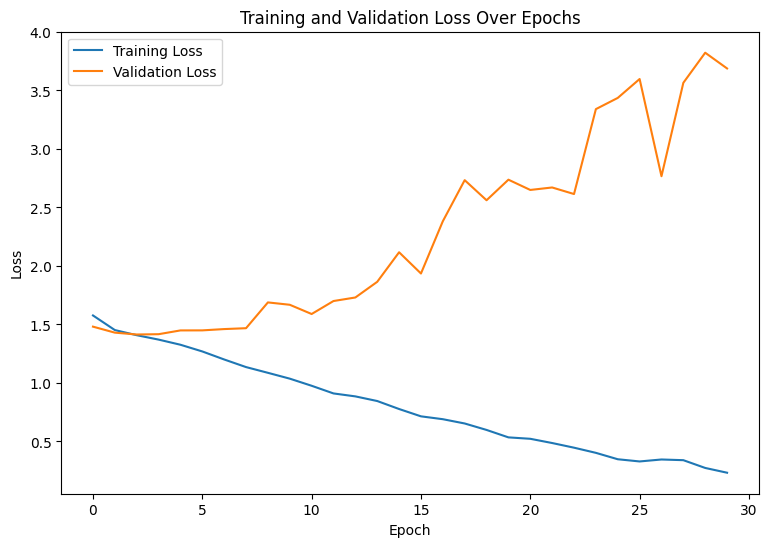

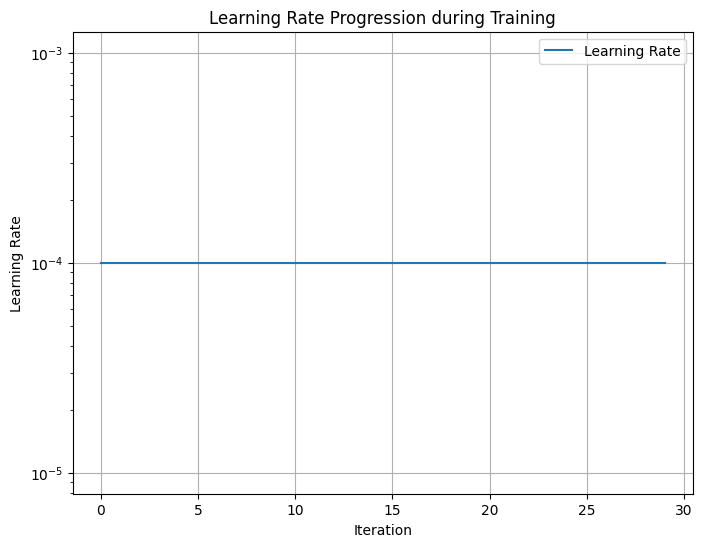

In [22]:
with open('2003v1/history_train_val.pkl', 'rb') as f:
    history = pickle.load(f)
    history_train = history['history_train']
    history_val = history['history_val']

plt.figure(figsize=(9, 6))
plt.plot(history_train, label='Training Loss')
plt.plot(history_val, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
#plt.ylim(-0.5, 2)
#plt.xlim(400, 500)
plt.legend()
plt.title('Training and Validation Loss Over Epochs')
plt.show()

with open('2003v1/learning_rates.pkl', 'rb') as f:
    learning_rates = pickle.load(f)

plt.figure(figsize=(8, 6))
plt.plot(learning_rates, label='Learning Rate')
plt.xlabel('Iteration')
plt.ylabel('Learning Rate')
plt.title('Learning Rate Progression during Training')
plt.yscale('log') 
plt.legend()
plt.grid(True)
plt.show()

this is where we load in the params that will unnormalize our results

In [23]:
with open("/raid5b/users/ilaing/MY_RESEARCH/params_loa.pkl", "rb") as f:
    params = pickle.load(f)

In [24]:
model.eval()
with torch.no_grad():
    feh_exp, feh_pred, feh_error = [], [], []
    logg_exp, logg_pred, logg_error = [], [], []
    teff_exp, teff_pred, teff_error = [], [], []
    mgfe_exp, mgfe_pred, mgfe_error = [], [], []
    cfe_exp, cfe_pred, cfe_error = [], [], []
    sife_exp, sife_pred, sife_error = [], [], []
    nife_exp, nife_pred, nife_error = [], [], []
    alfe_exp, alfe_pred, alfe_error = [], [], []
    cafe_exp, cafe_pred, cafe_error = [], [], []
    nfe_exp, nfe_pred, nfe_error = [], [], []

    for i in range(len(X_test_raw)):
        X_sample = X_test_raw[i: i + 1]
        X_sample = scaler.transform(X_sample)
        X_sample = torch.tensor(X_sample, dtype=torch.float32)

        y_pred = model(X_sample)

        means = y_pred[0, :10]        # pred means
        log_scatter = y_pred[0, 10:]  # pred log scale stdevs

        std_devs = torch.exp(log_scatter)  #un log it

        feh_pred.append(means[0].item())
        feh_error.append(std_devs[0].item())
        feh_exp.append(y_test[i][0])

        logg_pred.append(means[1].item())
        logg_error.append(std_devs[1].item())
        logg_exp.append(y_test[i][1])

        teff_pred.append(means[2].item())
        teff_error.append(std_devs[2].item())
        teff_exp.append(y_test[i][2])

        mgfe_pred.append(means[3].item())
        mgfe_error.append(std_devs[3].item())
        mgfe_exp.append(y_test[i][3])

        cfe_pred.append(means[4].item())
        cfe_error.append(std_devs[4].item())
        cfe_exp.append(y_test[i][4])

        sife_pred.append(means[5].item())
        sife_error.append(std_devs[5].item())
        sife_exp.append(y_test[i][5])

        nife_pred.append(means[6].item())
        nife_error.append(std_devs[6].item())
        nife_exp.append(y_test[i][6])
        
        alfe_pred.append(means[7].item())
        alfe_error.append(std_devs[7].item())
        alfe_exp.append(y_test[i][7])
        
        cafe_pred.append(means[8].item())
        cafe_error.append(std_devs[8].item())
        cafe_exp.append(y_test[i][8])
        
        nfe_pred.append(means[9].item())
        nfe_error.append(std_devs[9].item())
        nfe_exp.append(y_test[i][9])

In [25]:
feh_exp = np.array(feh_exp)
feh_pred = np.array(feh_pred)
feh_error = np.array(feh_error)

logg_exp = np.array(logg_exp)
logg_pred = np.array(logg_pred)
logg_error = np.array(logg_error)

teff_exp = np.array(teff_exp)
teff_pred = np.array(teff_pred)
teff_error = np.array(teff_error)

mgfe_exp = np.array(mgfe_exp)
mgfe_pred = np.array(mgfe_pred)
mgfe_error = np.array(mgfe_error)

cfe_exp = np.array(cfe_exp)
cfe_pred = np.array(cfe_pred)
cfe_error = np.array(cfe_error)

sife_exp = np.array(sife_exp)
sife_pred = np.array(sife_pred)
sife_error = np.array(sife_error)

nife_exp = np.array(nife_exp)
nife_pred = np.array(nife_pred)
nife_error = np.array(nife_error)

alfe_exp = np.array(alfe_exp)
alfe_pred = np.array(alfe_pred)
alfe_error = np.array(alfe_error)

cafe_exp = np.array(cafe_exp)
cafe_pred = np.array(cafe_pred)
cafe_error = np.array(cafe_error)

nfe_exp = np.array(nfe_exp)
nfe_pred = np.array(nfe_pred)
nfe_error = np.array(nfe_error)

In [26]:
# Unnormalise them all

#FE_H
feh_pred_unnorm = feh_pred * params['feh']['IQR'] + params['feh']['median']
feh_exp_unnorm  = feh_exp  * params['feh']['IQR'] + params['feh']['median']
feh_error_unnorm = feh_error * params['feh']['IQR']

#LOGG
logg_pred_unnorm = logg_pred * params['logg']['IQR'] + params['logg']['median']
logg_exp_unnorm  = logg_exp  * params['logg']['IQR'] + params['logg']['median']
logg_error_unnorm = logg_error * params['logg']['IQR']

#TEFF, note: teff was normalised in log10 space.
log_teff_pred = teff_pred * params['teff']['log_IQR'] + params['teff']['log_median']
teff_pred_unnorm = 10 ** log_teff_pred

log_teff_exp = teff_exp * params['teff']['log_IQR'] + params['teff']['log_median']
teff_exp_unnorm = 10 ** log_teff_exp

log_teff_error = teff_error * params['teff']['log_IQR']
teff_error_unnorm = teff_pred_unnorm * np.log(10) * log_teff_error

#MG_FE
mgfe_pred_unnorm = mgfe_pred * params['mgfe']['IQR'] + params['mgfe']['median']
mgfe_exp_unnorm  = mgfe_exp  * params['mgfe']['IQR'] + params['mgfe']['median']
mgfe_error_unnorm = mgfe_error * params['mgfe']['IQR']

#C_FE
cfe_pred_unnorm = cfe_pred * params['cfe']['IQR'] + params['cfe']['median']
cfe_exp_unnorm  = cfe_exp  * params['cfe']['IQR'] + params['cfe']['median']
cfe_error_unnorm = cfe_error * params['cfe']['IQR']

#SI_FE
sife_pred_unnorm = sife_pred * params['sife']['IQR'] + params['sife']['median']
sife_exp_unnorm  = sife_exp  * params['sife']['IQR'] + params['sife']['median']
sife_error_unnorm = sife_error * params['sife']['IQR']

#NI_FE
nife_pred_unnorm = nife_pred * params['nife']['IQR'] + params['nife']['median']
nife_exp_unnorm  = nife_exp  * params['nife']['IQR'] + params['nife']['median']
nife_error_unnorm = nife_error * params['nife']['IQR']

# AL_FE
alfe_pred_unnorm = alfe_pred * params['alfe']['IQR'] + params['alfe']['median']
alfe_exp_unnorm  = alfe_exp  * params['alfe']['IQR'] + params['alfe']['median']
alfe_error_unnorm = alfe_error * params['alfe']['IQR']

#CA_FE
cafe_pred_unnorm = cafe_pred * params['cafe']['IQR'] + params['cafe']['median']
cafe_exp_unnorm  = cafe_exp  * params['cafe']['IQR'] + params['cafe']['median']
cafe_error_unnorm = cafe_error * params['cafe']['IQR']

#N_FE
nfe_pred_unnorm = nfe_pred * params['nfe']['IQR'] + params['nfe']['median']
nfe_exp_unnorm  = nfe_exp  * params['nfe']['IQR'] + params['nfe']['median']
nfe_error_unnorm = nfe_error * params['nfe']['IQR']

In [37]:
import numpy as np
import matplotlib.pyplot as plt

def chi2_fn(observed, expected, error):
    return np.mean(((observed - expected) ** 2) / error ** 2)

def rmse_fn(observed, expected):
    return np.sqrt(np.mean((observed - expected) ** 2))

def print_stats(param_name, pred, exp, err):
    res = pred - exp
    median_error = np.percentile(err, 50)
    mean_residual = np.mean(res)
    median_residual = np.median(res)
    std_residual = np.std(res)
    chi2 = chi2_fn(exp, pred, err) 
    rmse = rmse_fn(exp, pred)
    
    iqr_val = np.percentile(res, 75) - np.percentile(res, 25)

    print(f"\n==== {param_name.upper()} ====")
    print(f"Median error: {median_error:.4f}")
    print(f"Mean residual: {mean_residual:.4f}")
    print(f"Median residual: {median_residual:.4f}")
    print(f"Std of residuals: {std_residual:.4f}")
    print(f"IQR of residuals: {iqr_val:.4f}")
    print(f"Chi²: {chi2:.4f}")
    print(f"RMSE: {rmse:.4f}")

In [40]:
def plot_pred_vs_exp(param_name, pred, exp):
    plt.figure(figsize=(6, 6))
    plt.scatter(exp, pred, s=2, alpha=0.5, color='dodgerblue')
    plt.plot([min(exp), max(exp)], [min(exp), max(exp)], 'r--')
    plt.xlabel(f'APOGEE {param_name.upper()}')
    plt.ylabel(f'Predicted {param_name.upper()}')
    plt.title(f'Prediction vs Expected for {param_name.upper()}')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_2d_hist(param_name, pred, exp, cmap):
    plt.figure(figsize=(6, 5))
    plt.hist2d(exp, pred, bins=100, cmap=cmap)
    plt.plot([min(exp), max(exp)], [min(exp), max(exp)], 'r--')
    plt.xlabel(f'APOGEE {param_name.upper()}')
    plt.ylabel(f'Predicted {param_name.upper()}')
    plt.title(f'2D Histogram: Predicted vs Expected for {param_name.upper()}')
    plt.colorbar(label='Density')
    plt.tight_layout()
    plt.show()


==== FEH ====
Median error: 0.3733
Mean residual: 0.0492
Median residual: -0.0180
Std of residuals: 0.4060
IQR of residuals: 0.4020
Chi²: 1.1558
RMSE: 0.4090


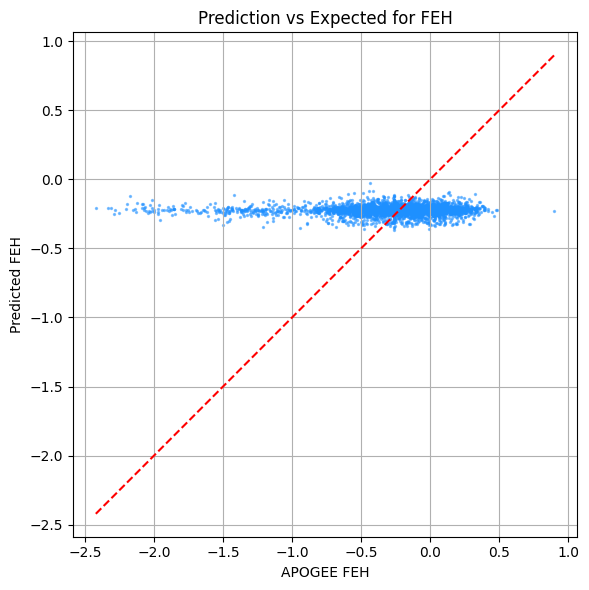

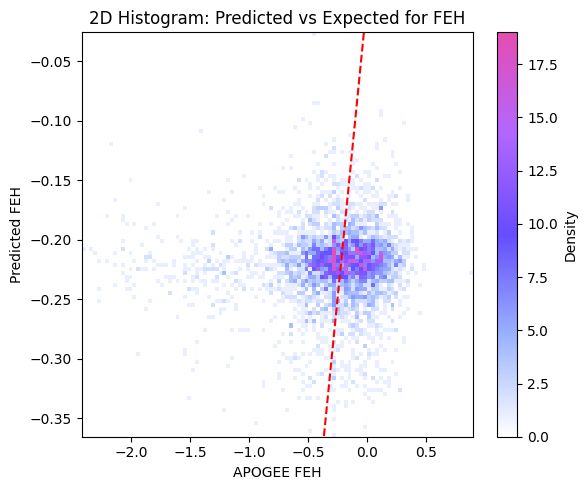


==== LOGG ====
Median error: 1.3150
Mean residual: 0.1334
Median residual: -0.0676
Std of residuals: 0.9810
IQR of residuals: 1.7284
Chi²: 0.5724
RMSE: 0.9900


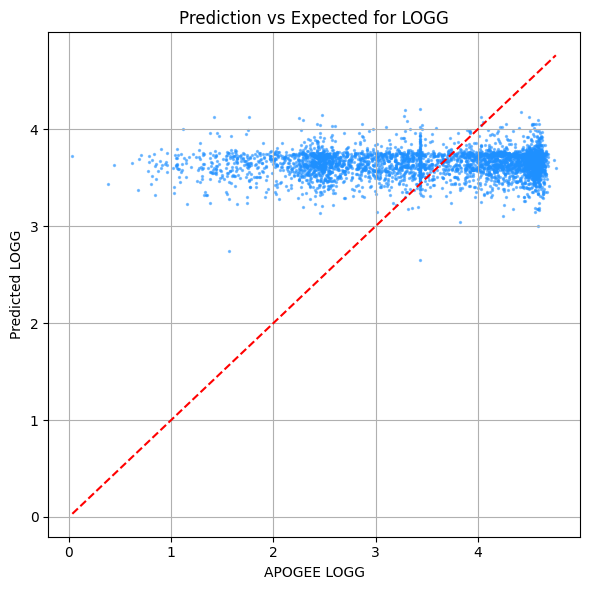

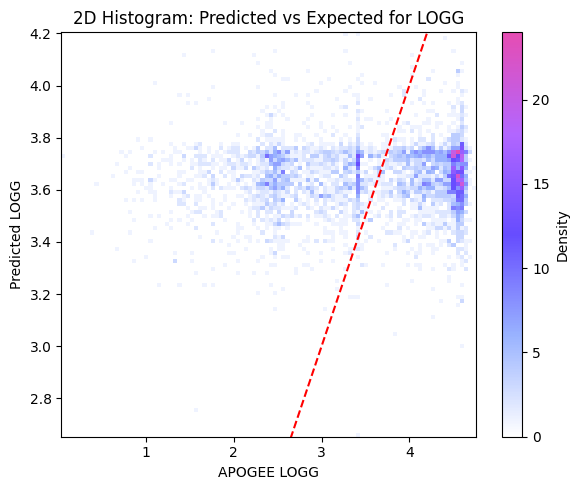


==== TEFF ====
Median error: 560.2036
Mean residual: -66.1982
Median residual: 16.2397
Std of residuals: 526.0969
IQR of residuals: 704.8881
Chi²: 0.9437
RMSE: 530.2454


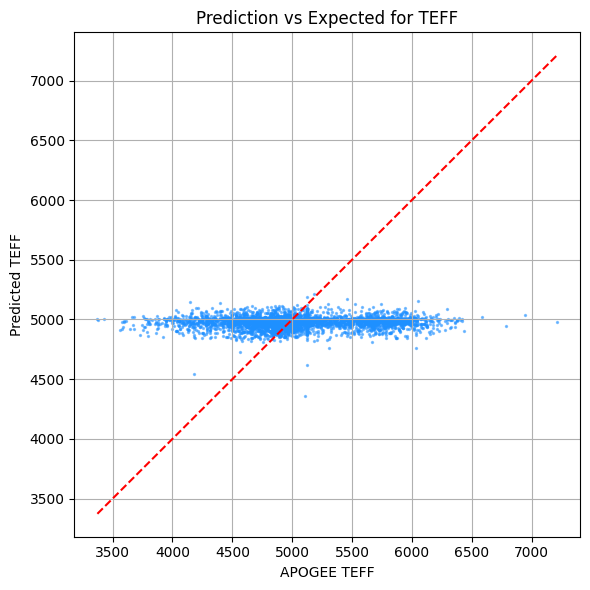

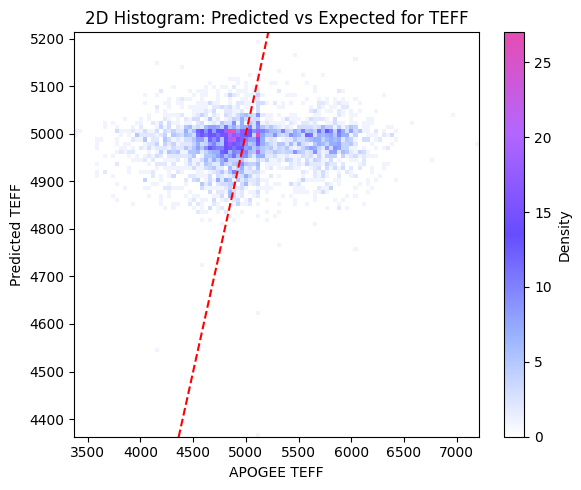


==== MGFE ====
Median error: 0.1668
Mean residual: 0.0099
Median residual: 0.0317
Std of residuals: 0.1360
IQR of residuals: 0.1855
Chi²: 0.7169
RMSE: 0.1364


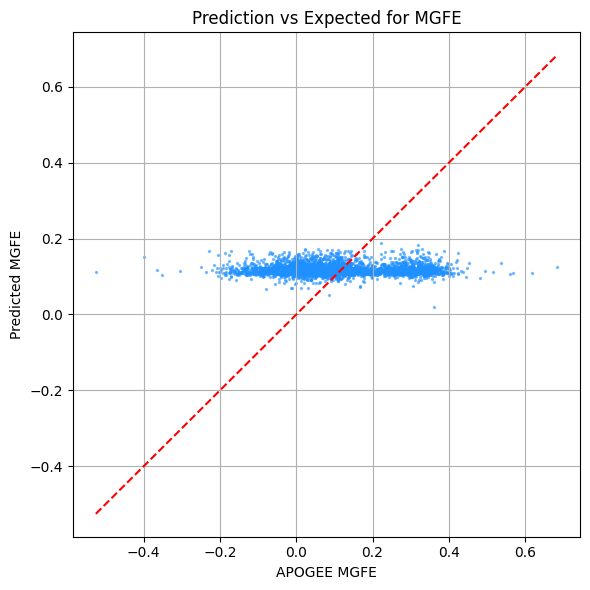

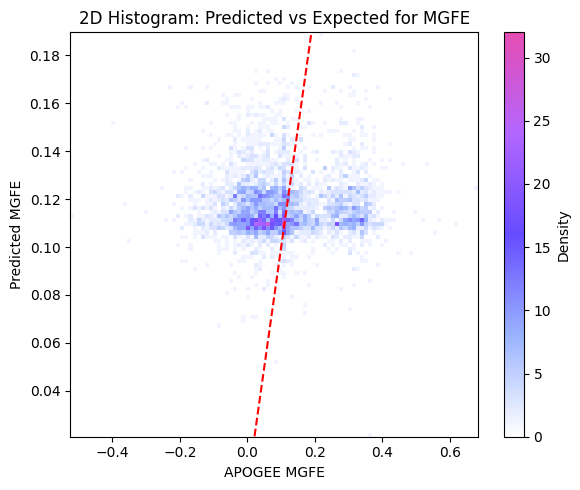


==== CFE ====
Median error: 0.1186
Mean residual: 0.0024
Median residual: -0.0049
Std of residuals: 0.1409
IQR of residuals: 0.1126
Chi²: 1.3744
RMSE: 0.1410


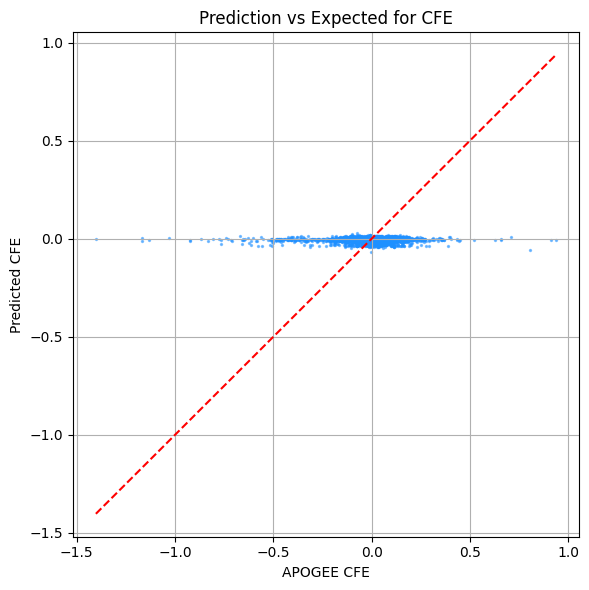

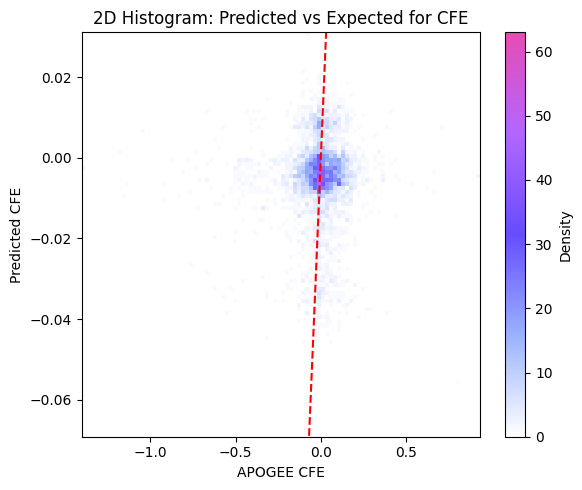


==== SIFE ====
Median error: 0.0990
Mean residual: -0.0026
Median residual: 0.0061
Std of residuals: 0.0952
IQR of residuals: 0.1149
Chi²: 0.9455
RMSE: 0.0952


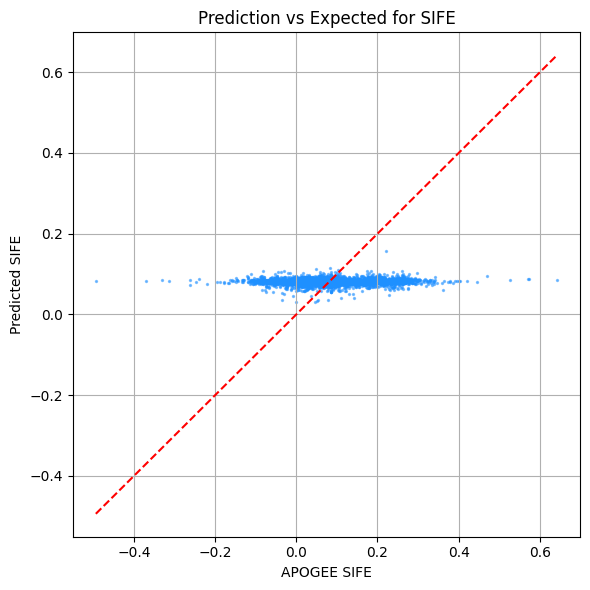

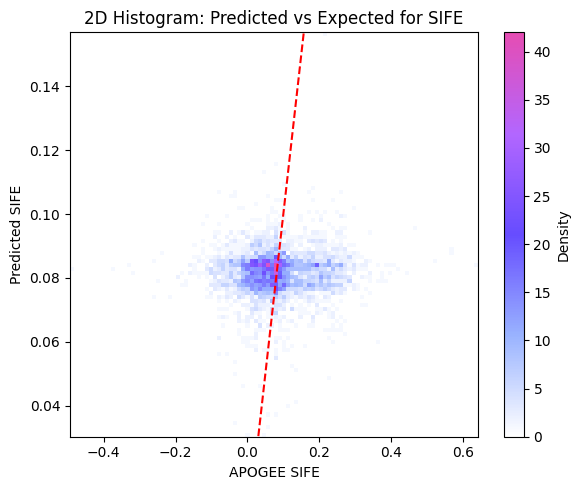


==== NIFE ====
Median error: 0.0572
Mean residual: -0.0040
Median residual: -0.0077
Std of residuals: 0.0743
IQR of residuals: 0.0658
Chi²: 1.6826
RMSE: 0.0744


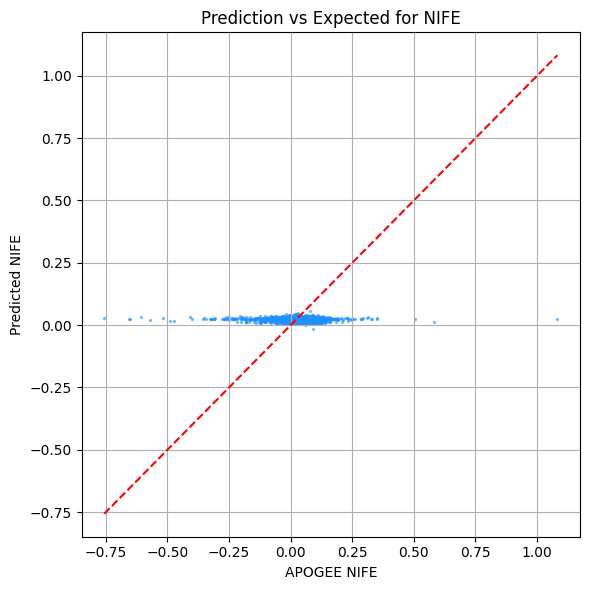

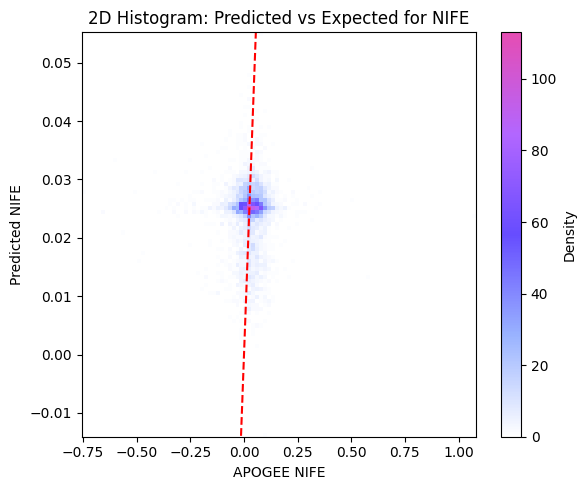


==== ALFE ====
Median error: 0.1521
Mean residual: 0.0002
Median residual: -0.0073
Std of residuals: 0.1448
IQR of residuals: 0.1432
Chi²: 0.9166
RMSE: 0.1448


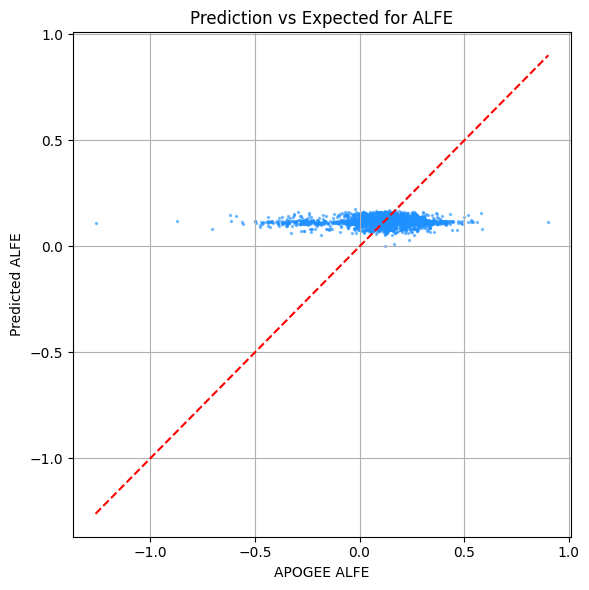

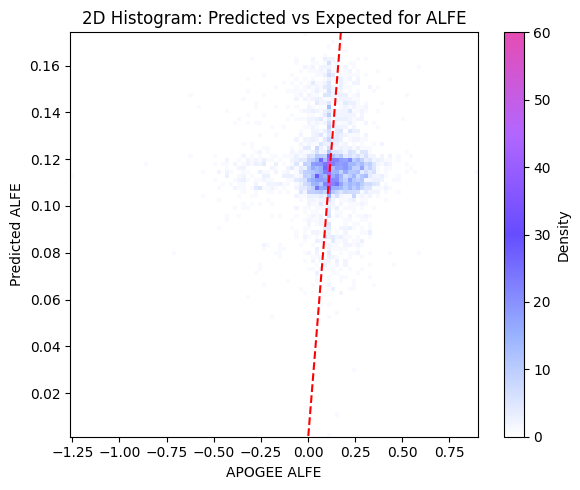


==== CAFE ====
Median error: 0.1148
Mean residual: -0.0029
Median residual: 0.0111
Std of residuals: 0.1136
IQR of residuals: 0.1196
Chi²: 0.9323
RMSE: 0.1137


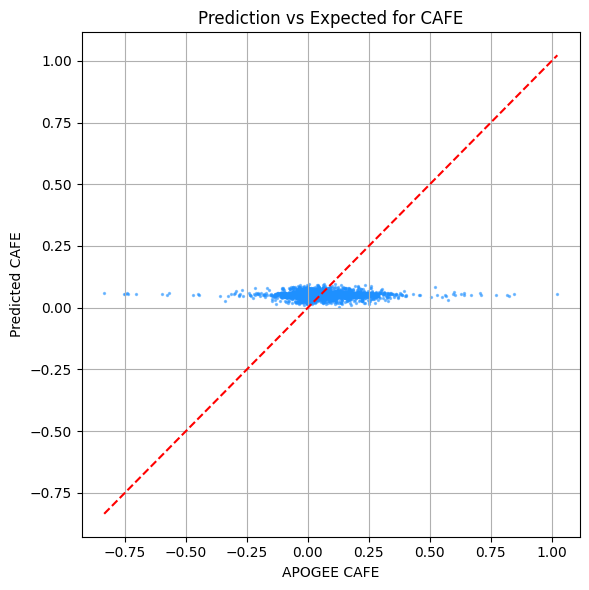

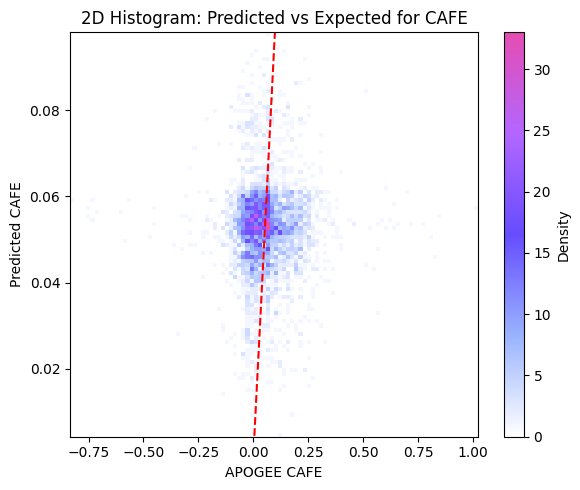


==== NFE ====
Median error: 0.1670
Mean residual: 0.0077
Median residual: 0.0110
Std of residuals: 0.2029
IQR of residuals: 0.1758
Chi²: 1.4415
RMSE: 0.2030


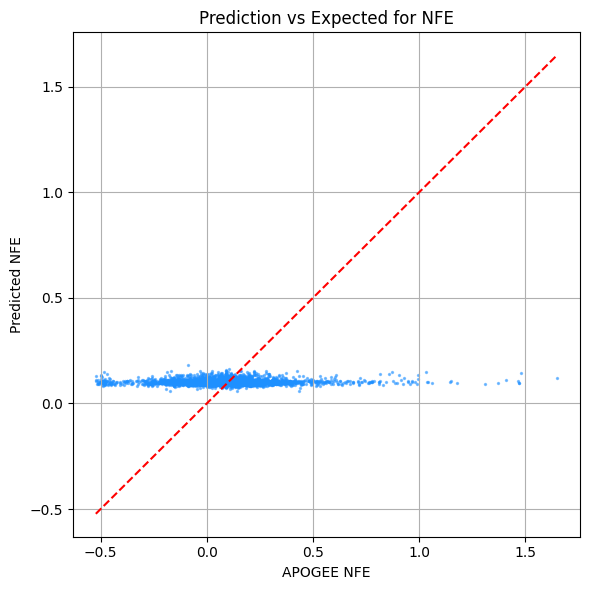

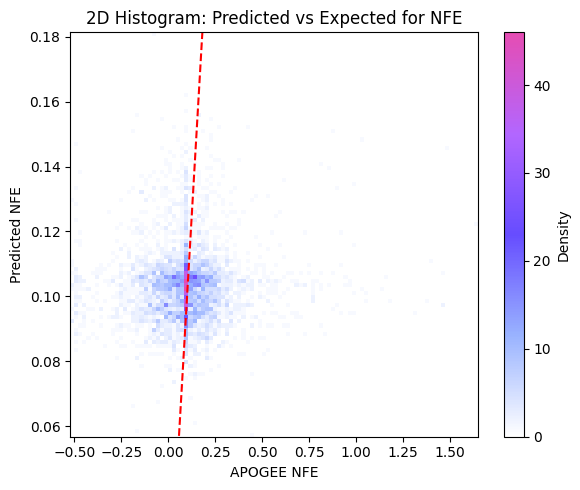

In [41]:
param_list = ['feh', 'logg', 'teff', 'mgfe', 'cfe', 'sife', 'nife', 'alfe', 'cafe', 'nfe']

for param in param_list:
    pred = globals()[f'{param}_pred_unnorm']
    exp = globals()[f'{param}_exp_unnorm']
    err = globals()[f'{param}_error_unnorm']

    print_stats(param, pred, exp, err)
    plot_pred_vs_exp(param, pred, exp)
    plot_2d_hist(param, pred, exp, cmap)

In [21]:
feh_err = feh_error * params['feh']['IQR']

logg_err = logg_error * params['logg']['IQR']

teff_err = teff_error * params['teff']['IQR']

#teff_errors = teff_error * log_teff_IQR  
#teff_err = teff_errors * (10**(teff_pred)) * np.log(10)
#np.percentile(teff_err, 50)

mgfe_err = mgfe_error * params['mgfe']['IQR']
      
cfe_err = cfe_error * params['cfe']['IQR']

sife_err = sife_error * params['sife']['IQR']

nife_err = nife_error * params['nife']['IQR']

alfe_err = alfe_error * params['alfe']['IQR']

cafe_err = cafe_error * params['cafe']['IQR']

nfe_err = nfe_error * params['nfe']['IQR']

everything underneath is just yap

In [22]:
data = {
    "feh": {"exp": feh_exp, "pred": feh_pred, "error": feh_err},
    "logg": {"exp": logg_exp, "pred": logg_pred, "error": logg_err},
    "mgfe": {"exp": mgfe_exp, "pred": mgfe_pred, "error": mgfe_err},
    "cfe": {"exp": cfe_exp, "pred": cfe_pred, "error": cfe_err},
    "sife": {"exp": sife_exp, "pred": sife_pred, "error": sife_err},
    "nife": {"exp": nife_exp, "pred": nife_pred, "error": nife_err},
    "alfe": {"exp": alfe_exp, "pred": alfe_pred, "error": alfe_err},
    "cafe": {"exp": cafe_exp, "pred": cafe_pred, "error": cafe_err},
    "nfe": {"exp": nfe_exp, "pred": nfe_pred, "error": nfe_err},
}

original_values = {
    "exp": {},  
    "pred": {}, 
}

for param, values in data.items():
    exp = values["exp"]
    pred = values["pred"]
    
    exp_original = (exp * params[param]["IQR"]) + params[param]["median"]
    pred_original = (pred * params[param]["IQR"]) + params[param]["median"]

    original_values["exp"][param] = exp_original
    original_values["pred"][param] = pred_original

In [23]:
def chi2_fn(observed, expected, error):
    return np.mean(((observed - expected) ** 2) / error ** 2)

def rmse_fn(observed, expected):
    return np.sqrt(np.mean((observed - expected) ** 2))

Median error is  0.398798750635577
Mean of residuals is  -0.010732430876178327
Median of residuals is  -0.17076638527214527
Standard deviation of res: 0.9906391043774209
chi2 for feh is  27263.3616720614
rmse for feh is  0.9906972394198998


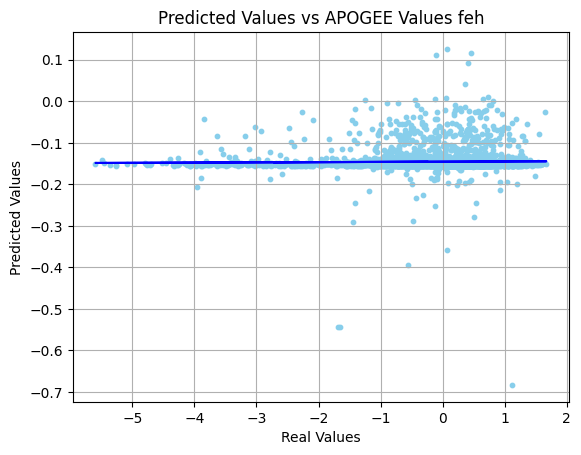

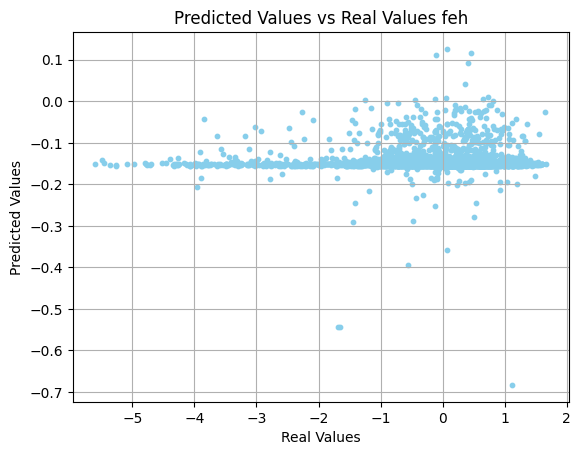

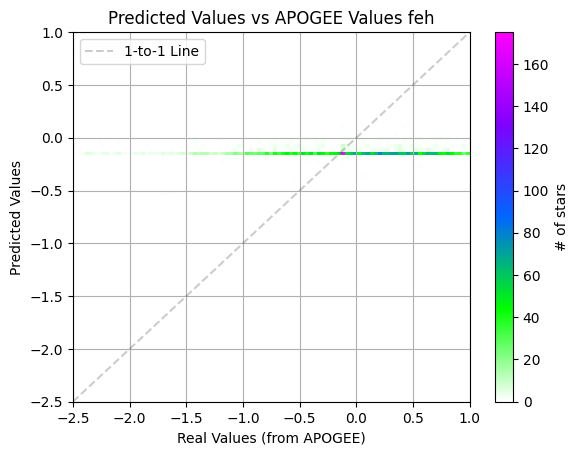

In [24]:
#Fe/H
feh_exp_original = feh_exp
feh_pred_original = feh_pred

res = np.array(feh_pred_original) - np.array(feh_exp_original)
percentile_25 = np.percentile(res, 25)
percentile_75 = np.percentile(res, 75)
iqr_value = (percentile_75 - percentile_25) 

print("Median error is ", np.percentile(feh_err, 50))
print("Mean of residuals is ", np.mean(res))
print("Median of residuals is ", np.median(res))
print("Standard deviation of res:", np.std(res))
print("chi2 for feh is ", chi2_fn(feh_exp_original, feh_pred_original, 0.006))
print("rmse for feh is ", rmse_fn(feh_exp_original, feh_pred_original))

plt.scatter(feh_exp_original, feh_pred_original, color='skyblue', s=10)
plt.xlabel('Real Values')
plt.ylabel('Predicted Values')
plt.title('Predicted Values vs APOGEE Values feh')
plt.grid(True)
#plt.xlim(-3, 1)
#plt.ylim(-3, 1)
z = np.polyfit(feh_exp_original, feh_pred_original, 1)
p = np.poly1d(z)
plt.plot(feh_exp_original, p(feh_exp_original), color="blue")
plt.show()

plt.scatter(feh_exp_original, feh_pred_original, color='skyblue', s=10)
plt.xlabel('Real Values')
plt.ylabel('Predicted Values')
plt.title('Predicted Values vs Real Values feh')
plt.grid(True)
#plt.xlim(-3, 1)
#plt.ylim(-3, 1)
plt.show()

plt.hist2d(feh_exp_original, feh_pred_original, bins=(np.linspace(-2.5, 1, 100), np.linspace(-2.5, 1, 100)), cmap=cmap)
plt.colorbar(label='# of stars')
xlim = plt.gca().get_xlim()
ylim = plt.gca().get_ylim()
plt.plot([xlim[0], xlim[1]], [ylim[0], ylim[1]], 'k--', label='1-to-1 Line', alpha = 0.2)
plt.xlabel('Real Values (from APOGEE)')
plt.ylabel('Predicted Values')
plt.title('Predicted Values vs APOGEE Values feh')
plt.grid(True)
plt.legend()
plt.show()

In [69]:
data = {
    "feh": {"exp": feh_exp, "pred": feh_pred, "error": feh_err},
    "logg": {"exp": logg_exp, "pred": logg_pred, "error": logg_err},
    "mgfe": {"exp": mgfe_exp, "pred": mgfe_pred, "error": mgfe_err},
    "cfe": {"exp": cfe_exp, "pred": cfe_pred, "error": cfe_err},
    "sife": {"exp": sife_exp, "pred": sife_pred, "error": sife_err},
    "nife": {"exp": nife_exp, "pred": nife_pred, "error": nife_err},
    "alfe": {"exp": alfe_exp, "pred": alfe_pred, "error": alfe_err},
    "cafe": {"exp": cafe_exp, "pred": cafe_pred, "error": cafe_err},
    "nfe": {"exp": nfe_exp, "pred": nfe_pred, "error": nfe_err},
}

original_values = {
    "exp": {},
    "pred": {},
}

filtered_values = {
    "exp": {},
    "pred": {},
}

tolerance = 1e-6

for param, values in data.items():
    exp = values["exp"]
    pred = values["pred"]

    exp_original = (exp * params[param]["IQR"]) + params[param]["median"]
    pred_original = (pred * params[param]["IQR"]) + params[param]["median"]

    original_values["exp"][param] = exp_original
    original_values["pred"][param] = pred_original

    mask = np.abs(exp_original - params[param]["mean"]) > tolerance

    filtered_values["exp"][param] = exp_original[mask]
    filtered_values["pred"][param] = pred_original[mask]

    num_removed = np.sum(~mask)
    print(f"{param.upper()}: Filtered out {num_removed} values.")

FEH: Filtered out 156 values.
LOGG: Filtered out 0 values.
MGFE: Filtered out 0 values.
CFE: Filtered out 0 values.
SIFE: Filtered out 0 values.
NIFE: Filtered out 0 values.
ALFE: Filtered out 431 values.
CAFE: Filtered out 0 values.
NFE: Filtered out 472 values.
